In [2]:
from datasets import load_dataset
import torch

from PIL import Image
from torch.utils.data import Dataset
from typing import Dict,List,Tuple
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.preprocessing import MultiLabelBinarizer
import pathlib
from modular import utils, data_setup
from pathlib import Path
import os
from datasets import load_dataset, load_from_disk


from pathlib import Path
from datasets import load_from_disk
data_dir = Path('data/')
image_dir = data_dir / '16kColorMulti'



Data Processing <a name='b2'/>

In [3]:
from torchvision import transforms
from modular import data_setup
import pathlib
from pathlib import Path
data_dir = Path('data/')
image_dir = data_dir / '16kColorMulti'
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
from modular import data_setup, utils, model_builder
from tqdm.auto import tqdm

model_dir = Path('models')
# model_path = model_dir / 'efficient_netv2.pth'
classes = utils.load_json(image_dir/'attributes.json')
model_v1 = model_builder.EfficientNetB0V1(output_shape=len(classes), device=device)
# model_v1.load_state_dict(torch.load(f=model_path))
# model_v1.summary()

In [5]:
from modular import utils
model_dir = Path('models')
model_name = 'efficient_netv3.pth'
model_save_path = model_dir / model_name
# torch.save(obj=model_v1.state_dict(), f=model_save_path)
# utils.save_model(model=model_v1,
#                  target_dir=model_dir,
#                  model_name=model_name)

In [6]:
import numpy as np
def plot_bar_chart(report, criteria):
    label_split = len(report) - 4
    x = list(report.keys())[:label_split]
    y = [x['precision'] for x in report.values()][:label_split]
    y1 = [x['recall'] for x in report.values()][:label_split]
    X_axis =  np.arange(len(x))
    plt.bar(X_axis - 0.2, y, 0.4, label = 'precision') 
    plt.bar(X_axis + 0.2, y1, 0.4, label = 'recall') 
    plt.xticks(X_axis, x) 
    plt.legend()
    

In [7]:
from modular import model_builder, metrics

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.1)
    
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229,0.224,0.225])
])

train_dataloader, test_dataloader, classes = data_setup.create_dataloaders(image_dir=image_dir,
                                                                   batch_size=128,
                                                                   train_transform=train_transform,
                                                                  test_transform=test_transform)
pos_weight = utils.calculate_pos_weight(dataset=train_dataloader.dataset)



  0%|          | 0/26137 [00:00<?, ?it/s]

In [8]:
model_v2 = model_builder.EfficientNetB0V1(output_shape=len(classes), device=device)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
optimizer = torch.optim.Adam(lr=0.0001, params=model_v2.parameters(), weight_decay=0.0001)
accuracy_fn = metrics.lrap_fn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


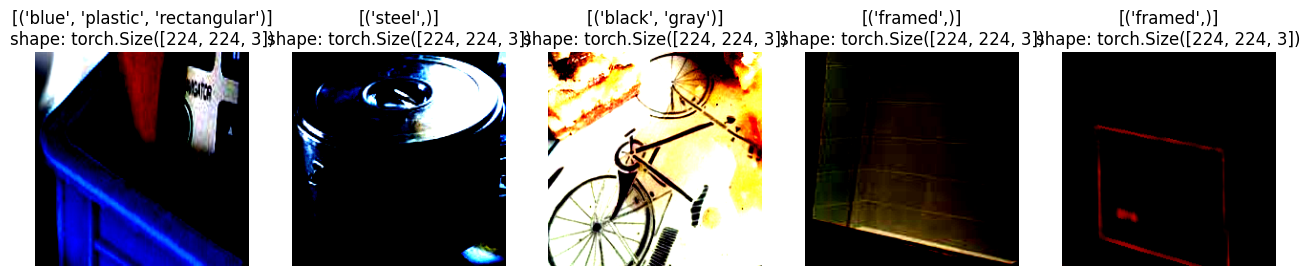

In [9]:
utils.display_random_images(dataset=train_dataloader.dataset, n=5, classes=classes)

In [10]:
from modular import engine
model_v2_results = engine.train(model=model_v2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                accuracy_fn=accuracy_fn,
                                device=device,
                                loss_fn=loss_fn,
                                epochs=100,
                                patience=7,
                                model_dir=model_dir,
                                model_name='2510-70atr.pth'
                                )

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
--------------------------
Train loss: 1.3192378067388768 | Train acc : 0.148078688283821| Test loss: 1.2698723387259703 | Test acc: 0.2250257709750074
[INFO] Saving model to: models\2510-70atr.pth
Epoch: 1
--------------------------
Train loss: 1.242033538004247 | Train acc : 0.24538706050878456| Test loss: 1.2085483888020883 | Test acc: 0.29266280672492617
[INFO] Saving model to: models\2510-70atr.pth
Epoch: 2
--------------------------
Train loss: 1.186961749123364 | Train acc : 0.29643049126679094| Test loss: 1.1666480703995779 | Test acc: 0.32254405169291556
[INFO] Saving model to: models\2510-70atr.pth
Epoch: 3
--------------------------
Train loss: 1.1436847387290583 | Train acc : 0.32166064759331336| Test loss: 1.1303848910790224 | Test acc: 0.33933004413323936
[INFO] Saving model to: models\2510-70atr.pth
Epoch: 4
--------------------------
Train loss: 1.1102316783695687 | Train acc : 0.3375117930812723| Test loss: 1.1038573934481695 | Test acc: 0.34752426446596324
[I

In [ ]:
utils.save_model(model=model_v2,
                 target_dir=model_dir,
                 model_name='2510-70atr.pth')

[INFO] Saving model to: models\2510-70atr.pth


WindowsPath('models/2510-70atr.pth')

In [ ]:
from modular import engine
eval_result = engine.evaluate_model(model=model_v1, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
eval_result

In [22]:
def plot_result(result):
        
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    train_loss = result['train_loss']
    test_loss = result['test_loss']
    train_acc = result['train_acc']
    test_acc = result['test_acc']
    x = range(len(train_loss))
    plt.plot(x, train_loss, label='train loss')
    plt.plot(x, test_loss, label='test loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x, train_acc, label='train acc')
    plt.plot(x, test_acc, label='test acc')
    plt.legend()

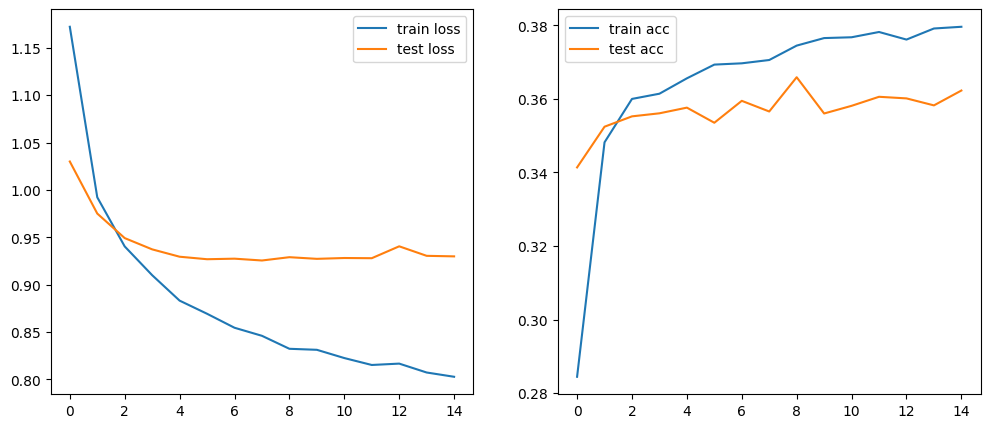

In [23]:

plot_result(model_v2_results)

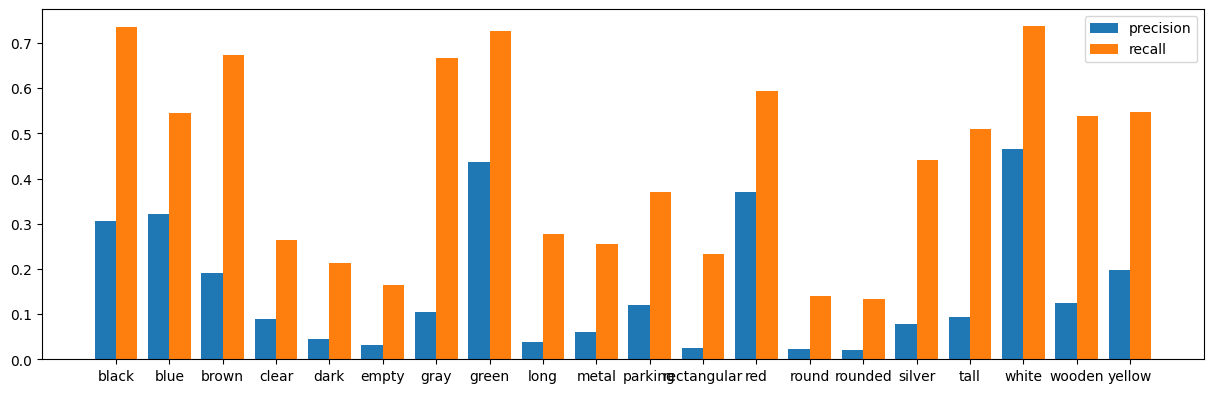

In [34]:
fig = plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plot_bar_chart(eval_result.report, 'precision')


In [7]:
eval_result.report



{'black': {'precision': 0.3057275884844236,
  'recall': 0.73634382049875,
  'f1-score': 0.4086423905158158,
  'support': 4.47887323943662},
 'blue': {'precision': 0.3219387029246184,
  'recall': 0.5448041188306308,
  'f1-score': 0.3687099730446015,
  'support': 2.9859154929577465},
 'brown': {'precision': 0.18990991402963228,
  'recall': 0.6744131455399062,
  'f1-score': 0.2843122600012235,
  'support': 2.4507042253521125},
 'clear': {'precision': 0.08920746702436844,
  'recall': 0.26291079812206575,
  'f1-score': 0.11922850232709392,
  'support': 0.4788732394366197},
 'dark': {'precision': 0.04597179033798751,
  'recall': 0.2124413145539906,
  'f1-score': 0.07142513198851227,
  'support': 0.5915492957746479},
 'empty': {'precision': 0.03210287365216943,
  'recall': 0.16431924882629106,
  'f1-score': 0.05131730554265766,
  'support': 0.4225352112676056},
 'gray': {'precision': 0.1048279484064066,
  'recall': 0.6657276995305165,
  'f1-score': 0.17217453768912744,
  'support': 1.88732394

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_precision(x,Y,label_name):  
    plt.plot(x, Y, label=label_name)
    plt.xlabel('Epoch')

def plot_score(list, name:str, criteria:str):
    train = list['train_result']
    test = list['test_result']
    x = range(len(train))
    ytrain = [x.report[name][criteria] for x in train]
    ytest=[x.report[name][criteria] for x in test]
    plt.title(name)
    plot_precision(x=x, Y=ytrain, label_name=f'Train {criteria}')
    plot_precision(x=x, Y=ytest, label_name=f'Test {criteria}')
    plt.legend(loc="upper left")

def plot_reportv1(list, name:str):
    plt.figure(figsize=(15,15))

    plt.subplot(2,2,1)
    plot_score(list, name=name, criteria='precision')
    plt.subplot(2,2,2)
    plot_score(list, name=name, criteria='recall')
    plt.subplot(2,2,3)
    plot_score(list, name=name, criteria='f1-score')





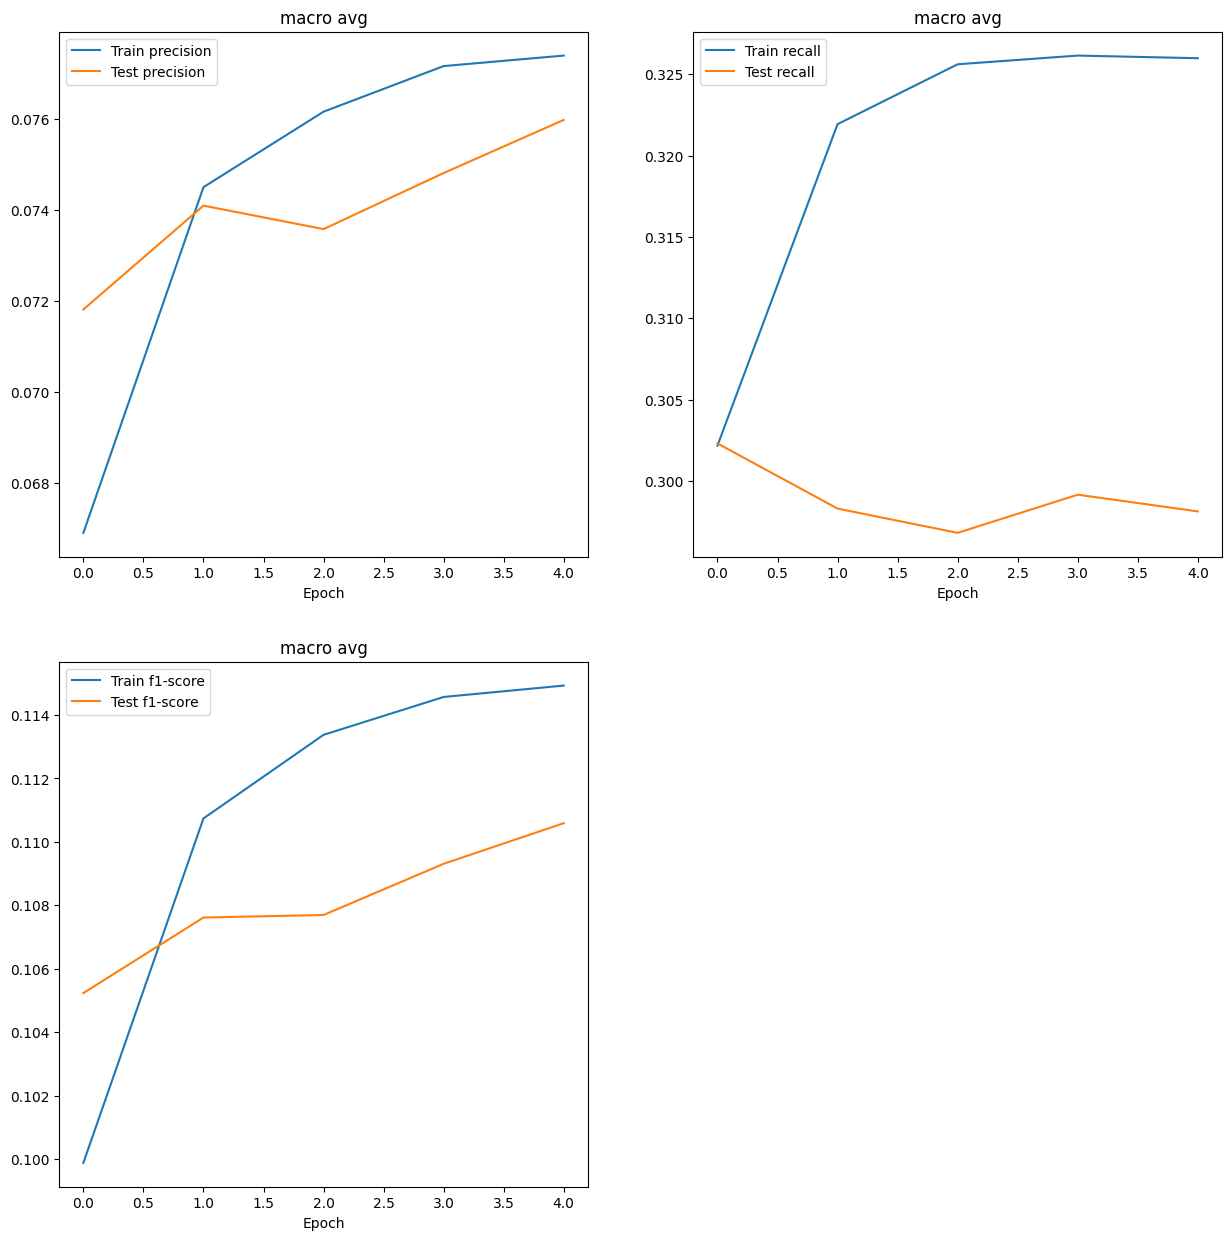

: 

In [48]:
plot_reportv1(model_v1_results, name='macro avg')

# print(model_v1_results['test_result'])

In [124]:
def plot_loss_curve(epoch_list, title):
    loss_seq = [epoch.loss for epoch in epoch_list]
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.plot(range(len(epoch_list)),loss_seq,  label='Loss')
    plt.xlabel('Epoch')